# [모의 캐글-의료] 흉부 CT 코로나 감염 여부 분류
- 이미지 binary 분류 과제

## 우리 팀이 학습한 방법
* **순서**
1. 기본 베이스라인 코드를 가지고 모델별로 성능을 확인해본다
  * CNN, DCNN, AlexNet, VGG, ResNet, EfficientNet...
2. 모델별로 돌려보고 하이퍼파라미터 튜닝 및 batch_size, image_size 등 조절
3. Data Augumentation을 통해 데이터를 뻥튀기 시켜서 성능이 올라가는 지 확인
4. k-fold 및 앙상블을 써서 성능을 향상시키도록 함.
  * hard voting, soft voting...

* 과적합 방지를 위해 Dropout, BatchNorm, Early Stopping 등을 사용함
* **1번과 3번 순서를 바꿔서도 진행해봄**

## 내가 한 역할
* 기본 베이스라인 코드를 가지고 모델별로 성능을 확인!
* 팀원이 진행한 Data Augumentation 코드를 받아서 적용시킨 후 다시 데이터 증식한 단게에서 모델별로 성능을 확인.

## Import Libraries

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!apt-get update && apt-get install -y python3-opencv

Get:1 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease [15.9 kB]
Hit:2 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Get:3 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Get:4 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu bionic InRelease [15.9 kB]
Get:5 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu bionic InRelease [21.3 kB]
Get:6 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Hit:7 http://archive.ubuntu.com/ubuntu bionic InRelease
Ign:8 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Get:9 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Ign:10 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Get:11 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release [696 B]
Hit:12 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_6

In [3]:
# !pip install sklearn

In [4]:
import os, torch, copy, cv2, sys, random
# from datetime import datetime, timezone, timedelta
from PIL import Image
import numpy as np
import pandas as pd
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
import torchvision.transforms as transforms

## Set Arguments & hyperparameters

In [5]:
# 시드(seed) 설정

RANDOM_SEED = 2022

torch.manual_seed(RANDOM_SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(RANDOM_SEED)
random.seed(RANDOM_SEED)

In [6]:
# parameters

### 데이터 디렉토리 설정 ###
DATA_DIR= '/content/drive/MyDrive/모의경진대회/흉부 CT를 이용한 데이터 분석/data'
NUM_CLS = 2

EPOCHS = 30
BATCH_SIZE = 32
LEARNING_RATE = 0.0005
EARLY_STOPPING_PATIENCE = 10
INPUT_SHAPE = 384

os.environ["CUDA_VISIBLE_DEVICES"]="0"
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## Dataloader
* 원본 이미지 shape (384, 384, 3)

## Data Augmentation 
 - 라이브러리 자체 Augmentation 모듈도 있지만 Albumentation이 연산 속도가 빨라서 선택!
 - 캐글러들도 많이 선택한다고 함.

#### Train & Validation Set loader

In [7]:
# ! pip install albumentations==0.4.6

In [8]:
import albumentations as A
from albumentations.pytorch import transforms as albu_transforms

In [9]:
class CustomDataset(Dataset):  # albu 넣어보기
    def __init__(self, data_dir, mode, input_shape, transform=None):
        self.data_dir = data_dir
        self.mode = mode
        self.input_shape = input_shape
        
        # Loading dataset
        self.db = self.data_loader()
        
        # Dataset split
        if self.mode in ['train', 'aug']:
            self.db = self.db[:int(len(self.db) * 0.9)]  # 앞 90% 불러오기
        elif self.mode == 'val':
            self.db = self.db[int(len(self.db) * 0.9):]  # 뒤 10% 불러오기
            self.db.reset_index(inplace=True)
        else:
            print(f'!!! Invalid split {self.mode}... !!!')
        
        self.transform = transform
        if self.transform:
            self.transform = transform
        else:
            # self.transform = A.Compose([A.Resize(256,256),
            #                             A.Normalize(mean=[0.485, 0.456, 0.406],
            #                                         std=[0.229, 0.224, 0.225],),
            #                             albu_transforms.ToTensorV2(),
            #                            ])
            self.transform = transforms.Compose([transforms.Resize(self.input_shape),  # 위에서 설정한 값으로 이미지 리사이즈
                                             transforms.ToTensor(),  # 이미지 텐서화
                                             transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])
            
    def data_loader(self):  # csv 파일 불러오기
        print('Loading ' + self.mode + ' dataset..')
        if not os.path.isdir(self.data_dir):
            print(f'!!! Cannot find {self.data_dir}... !!!')
            sys.exit()
        
        # (COVID : 1, No : 0)
        db = pd.read_csv(os.path.join(self.data_dir, 'train.csv'))
        return db

    def __len__(self):
        return len(self.db)

    def __getitem__(self, index):  # 각 데이터의 이미지 텐서, 라벨값 반환
        data = copy.deepcopy(self.db.loc[index])  # index번째 이미지 불러오기 -> 복사본 만들기(찐 데이터에 영향ㄴㄴ)
        
        label = data['COVID']
        file_path = os.path.join(self.data_dir,'train',data['file_name'])
        # Loading image
        cvimg = cv2.imread(file_path)
        cvimg = cv2.cvtColor(cvimg, cv2.COLOR_BGR2RGB)
        
        if not isinstance(cvimg, np.ndarray):
            raise IOError("Fail to read %s" % data['file_name'])  # 혹시 안되면 에러 띄우기

        # Preprocessing images
        if self.mode == 'aug':  # self.transform:
            cvimg = self.transform(image=cvimg)['image']
            # augmented = self.transform(image=cvimg)
            # cvimg = augmented['image']
        else:
            # cvimg = self.transform(image=cvimg)['image']
            cvimg = self.transform(Image.fromarray(cvimg))

        return cvimg, label  # 텐서로 변환된 이미지와 label 반환
    
    


### Albumentation

In [10]:
albumentations_transform = A.Compose([
    A.Resize(400, 400), # 256, 256
    A.RandomCrop(384, 384), # 224, 224
    A.HorizontalFlip(p=0.5),  # p의 확률로 좌우 반전
    A.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225],
    ),
    A.RandomBrightnessContrast(p=0.5),
    A.RandomRotate90(p=0.2),
    # A.Blur(),
    A.VerticalFlip(),
    
    albu_transforms.ToTensor()
])


In [11]:
# albumentations_transform2 = A.Compose([
#     A.Resize(400, 400), # 256, 256
#     A.RandomCrop(384, 384), # 224, 224
#     A.HorizontalFlip(p=0.5),  # p의 확률로 좌우 반전
#     A.Normalize(
#         mean=[0.485, 0.456, 0.406],
#         std=[0.229, 0.224, 0.225],
#     ),
#     A.RandomBrightnessContrast(p=0.5),
#     A.RandomRotate90(p=0.2),
#     # A.Blur(),
#     A.VerticalFlip(),
    
#     albu_transforms.ToTensor()
# ])

## Model

### CNN(LeNet)

In [12]:
import torch.nn.functional as F

class custom_CNN(nn.Module):
    def __init__(self, num_classes):
        super(custom_CNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=8, kernel_size=5) #62
        self.conv_bn1 = nn.BatchNorm2d(8)
        self.pool = nn.MaxPool2d(kernel_size=2)
        self.conv2 = nn.Conv2d(in_channels=8, out_channels=16, kernel_size=5)
        self.conv_bn2 = nn.BatchNorm2d(16)
        
        self.fc1 = nn.Linear(in_features=16*93*93, out_features=128)
        self.fc2 = nn.Linear(in_features=128, out_features=num_classes)
        self.softmax = nn.Softmax(dim=1)
        # self.dropout = nn.Dropout(p=0.5)
        
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x))) # (32, 3, 384, 384) -> (32, 8, 190, 190)
        x = self.conv_bn1(x)
        x = self.pool(F.relu(self.conv2(x))) # (32, 8, 190, 190) -> (32, 16, 93, 93)
        x = self.conv_bn2(x)
        
        x = torch.flatten(x,1)
        x = F.relu(self.fc1(x)) # (32, 128)
        x = F.relu(self.fc2(x)) # (32, 2)
        
        output = self.softmax(x) 
        return output

### DCNN

In [13]:
# #DCNN
# import torch.nn.functional as F

# class custom_CNN(nn.Module):
#     def __init__(self, num_classes):
#         super(custom_CNN, self).__init__()
#         self.conv1 = nn.Conv2d(in_channels=3, out_channels=8, kernel_size=5) #62
#         self.conv_bn1 = nn.BatchNorm2d(8)
#         self.pool = nn.MaxPool2d(kernel_size=2)
#         self.conv2 = nn.Conv2d(in_channels=8, out_channels=16, kernel_size=5)
#         self.conv_bn2 = nn.BatchNorm2d(16)
#         self.conv3 = nn.Conv2d(in_channels=16, out_channels=25, kernel_size=5)
#         self.conv_bn3 = nn.BatchNorm2d(25)
        
#         self.fc1 = nn.Linear(in_features=25*44*44, out_features=128)
#         self.fc2 = nn.Linear(in_features=128, out_features=num_classes)
#         self.softmax = nn.Softmax(dim=1)
        
#     def forward(self, x):
#         x = self.pool(F.relu(self.conv1(x))) # (32, 3, 384, 384) -> (32, 8, 190, 190)
#         x = self.conv_bn1(x)
#         x = self.pool(F.relu(self.conv2(x))) # (32, 8, 190, 190) -> (32, 16, 93, 93)
#         x = self.conv_bn2(x)
#         x = self.pool(F.relu(self.conv3(x))) # (32, 16, 93, 93) -> (32, 25, 44, 44)
#         x = self.conv_bn3(x)
        
#         x = torch.flatten(x,1)
#         x = F.relu(self.fc1(x)) # (32, 128)
#         x = F.relu(self.fc2(x)) # (32, 2)
        
#         output = self.softmax(x) 
#         return output

### AlexNet

In [ ]:
# #AlexNet
# import torch.nn.functional as F

# class AlexNet(nn.Module):
#     def __init__(self, num_classes, init_weights: bool = True):
#         super(AlexNet, self).__init__()
#         self.convnet = nn.Sequential(
#             # Input Channel (RGB: 3)
#             nn.Conv2d(in_channels=3, out_channels=8, kernel_size=5, padding=0, stride=4), # 384 -> 95
#             nn.ReLU(inplace=True),
#             nn.LocalResponseNorm(size=5, k=2),
#             nn.MaxPool2d(kernel_size=3, stride=2), # 95 -> 47
            
#             nn.Conv2d(in_channels=8, out_channels=16, kernel_size=5, padding=2, stride=1), # 47 -> 47
#             nn.ReLU(inplace=True),
#             nn.LocalResponseNorm(size=5, k=2),
#             nn.MaxPool2d(kernel_size=3, stride=2), # 47 -> 23
            
#             nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, padding=1, stride=1),
#             nn.ReLU(inplace=True),
#             nn.LocalResponseNorm(size=5, k=2),
#             nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1, stride=1),
#             nn.ReLU(inplace=True),
#             nn.LocalResponseNorm(size=5, k=2),
#             nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1, stride=1),
#             nn.ReLU(inplace=True),
#             nn.LocalResponseNorm(size=5, k=2),
#             nn.MaxPool2d(kernel_size=3, stride=2), # 23 -> 11
#         )

#         self.fclayer = nn.Sequential(
#             nn.Linear(128 * 11 * 11, 256),
#             nn.ReLU(inplace=True),
#             nn.Dropout(p=0.5),
#             nn.Linear(256, 512),
#             nn.ReLU(inplace=True),
#             nn.Dropout(p=0.5),
#             nn.Linear(512, num_classes),
#         )
#         self.softmax = nn.Softmax(dim=1)
    
#     def forward(self, x):
#         x = self.convnet(x)
#         x = torch.flatten(x, 1)
#         x = self.fclayer(x)
#         output = self.softmax(x)

#         return output
  

### VGG

In [14]:
# # VGG_13_bn

# import torch.nn.functional as F

# class VGG_B(nn.Module):
#     def __init__(self, num_classes, init_weights: bool = True):
#         super(VGG_B, self).__init__()
#         self.convnet = nn.Sequential(
#             # Input Channel (RGB: 3)
#             nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, padding=1, stride=1),
#             nn.ReLU(inplace=True),
#             nn.BatchNorm2d(64),
#             nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1, stride=1),
#             nn.ReLU(inplace=True),
#             nn.BatchNorm2d(64),
#             nn.MaxPool2d(kernel_size=2, stride=2), # 224 -> 112
            
#             nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1, stride=1),
#             nn.ReLU(inplace=True),
#             nn.BatchNorm2d(128),
#             nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1, stride=1),
#             nn.ReLU(inplace=True),
#             nn.BatchNorm2d(128),
#             nn.MaxPool2d(kernel_size=2, stride=2), # 112 -> 56
            
#             nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1, stride=1),
#             nn.ReLU(inplace=True),
#             nn.BatchNorm2d(256),
#             nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1, stride=1),
#             nn.ReLU(inplace=True),
#             nn.BatchNorm2d(256),
#             nn.MaxPool2d(kernel_size=2, stride=2), # 56 -> 28

#             nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, padding=1, stride=1),
#             nn.ReLU(inplace=True),
#             nn.BatchNorm2d(512),
#             nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1, stride=1),
#             nn.ReLU(inplace=True),
#             nn.BatchNorm2d(512),
#             nn.MaxPool2d(kernel_size=2, stride=2), # 28 -> 14

#             nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1, stride=1),
#             nn.ReLU(inplace=True),
#             nn.BatchNorm2d(512),
#             nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1, stride=1),
#             nn.ReLU(inplace=True),
#             nn.BatchNorm2d(512),
#             nn.MaxPool2d(kernel_size=2, stride=2), # 14 -> 7
#         )

#         self.fclayer = nn.Sequential(
#             nn.Linear(512 * 7 * 7, 4096),
#             nn.ReLU(inplace=True),
#             nn.Dropout(p=0.5),
#             nn.Linear(4096, 4096),
#             nn.ReLU(inplace=True),
#             nn.Dropout(p=0.5),
#             nn.Linear(4096, num_classes),
#         )
#         self.softmax = nn.Softmax(dim=1)
    
#     def forward(self, x):
#         x = self.convnet(x)
#         x = torch.flatten(x, 1)
#         x = self.fclayer(x)
#         output = self.softmax(x)

#         return output

In [15]:
# # VGG_16bn

# import torch.nn.functional as F

# class VGG_C(nn.Module):
#     def __init__(self, num_classes, init_weights: bool = True):
#         super(VGG_C, self).__init__()
#         self.convnet = nn.Sequential(
#             # Input Channel (RGB: 3)
#             nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, padding=1, stride=1),
#             nn.BatchNorm2d(64),
#             nn.ReLU(inplace=True),
#             nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1, stride=1),
#             nn.BatchNorm2d(64),
#             nn.ReLU(inplace=True),
#             nn.MaxPool2d(kernel_size=2, stride=2), # 384 -> 192
            
#             nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1, stride=1),
#             nn.BatchNorm2d(128),
#             nn.ReLU(inplace=True),
#             nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1, stride=1),
#             nn.BatchNorm2d(128),
#             nn.ReLU(inplace=True),
#             nn.MaxPool2d(kernel_size=2, stride=2), # 192 -> 96
            
#             nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1, stride=1),
#             nn.BatchNorm2d(256),
#             nn.ReLU(inplace=True),
#             nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1, stride=1),
#             nn.BatchNorm2d(256),
#             nn.ReLU(inplace=True),
#             nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1, stride=1),
#             nn.BatchNorm2d(256),
#             nn.ReLU(inplace=True),
#             nn.MaxPool2d(kernel_size=2, stride=2), # 96 -> 48

#             nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, padding=1, stride=1),
#             nn.BatchNorm2d(512),
#             nn.ReLU(inplace=True),
#             nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1, stride=1),
#             nn.BatchNorm2d(512),
#             nn.ReLU(inplace=True),
#             nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1, stride=1),
#             nn.BatchNorm2d(512),
#             nn.ReLU(inplace=True),
#             nn.MaxPool2d(kernel_size=2, stride=2), # 48 -> 24

#             nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1, stride=1),
#             nn.BatchNorm2d(512),
#             nn.ReLU(inplace=True),
#             nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1, stride=1),
#             nn.BatchNorm2d(512),
#             nn.ReLU(inplace=True),
#             nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1, stride=1),
#             nn.BatchNorm2d(512),
#             nn.ReLU(inplace=True),
#             nn.MaxPool2d(kernel_size=2, stride=2), # 24 -> 12
#         )

#         self.fclayer = nn.Sequential(
#             nn.Linear(512 * 12 * 12, 4096),
#             nn.ReLU(inplace=True),
#             nn.Dropout(p=0.5),
#             nn.Linear(4096, 4096),
#             nn.ReLU(inplace=True),
#             nn.Dropout(p=0.5),
#             nn.Linear(4096, num_classes),
#         )
#         self.softmax = nn.Softmax(dim=1)
    
#     def forward(self, x):
#         x = self.convnet(x)
#         x = torch.flatten(x, 1)
#         x = self.fclayer(x)
#         output = self.softmax(x)

#         return output

## ResNet

In [ ]:
# #Resnet

# import torchvision.models as models

# class ResNet(nn.Module):
#     def __init__(self, num_classes):
#         super(ResNet, self).__init__()
#         self.model = models.resnet18(pretrained=False)
#         self.model.fc = nn.Linear(self.model.fc.in_features, num_classes)
#         self.softmax = nn.Softmax(dim=1)
        
#     def forward(self, input_img):
#         x = self.model(input_img)
#         x = self.softmax(x)
#         return x

In [16]:
# # Efficientnet_b7

# import torchvision.models as models
# import torch.nn.functional as F

# class Efficientnet_b7(nn.Module):
#     def __init__(self, num_classes):
#         super(Efficientnet_b7, self).__init__()
#         self.model = models.efficientnet_b7(pretrained=False)
#         self.fclayer = nn.Sequential(
#             nn.Linear(1000, 512),
#             nn.ReLU(),
#             nn.Dropout(p=0.5),
#             nn.Linear(512, num_classes))
#         self.softmax = nn.Softmax(dim=1)
        
#     def forward(self, input_img):
#         x = self.model(input_img)
#         x = self.fclayer(x)
#         x = self.softmax(x)
#         return x

## Utils
### EarlyStopper

In [17]:
class LossEarlyStopper():
    """Early stopper
    
    Attributes:
        patience (int): loss가 줄어들지 않아도 학습할 epoch 수
        patience_counter (int): loss 가 줄어들지 않을 때 마다 1씩 증가, 감소 시 0으로 리셋
        min_loss (float): 최소 loss
        stop (bool): True 일 때 학습 중단

    """

    def __init__(self, patience: int)-> None:
        self.patience = patience

        self.patience_counter = 0
        self.min_loss = np.Inf
        self.stop = False
        self.save_model = False

    def check_early_stopping(self, loss: float)-> None:
        """Early stopping 여부 판단"""  

        if self.min_loss == np.Inf:
            self.min_loss = loss
            return None

        elif loss > self.min_loss:
            self.patience_counter += 1
            msg = f"Early stopping counter {self.patience_counter}/{self.patience}"

            if self.patience_counter == self.patience:
                self.stop = True
                
        elif loss <= self.min_loss:
            self.patience_counter = 0
            self.save_model = True
            msg = f"Validation loss decreased {self.min_loss} -> {loss}"
            self.min_loss = loss
        
        print(msg)

### Trainer

In [18]:
# 학습 데이터의 loss를 저장
running_loss_history = []
# 학습 데이터의 accuracy를 저장
running_corrects_history = []
# 평가 데이터의 loss를 저장
val_running_loss_history = []
# 평가 데이터의 accuracy를 저장
val_running_corrects_history = []

In [19]:
class Trainer():
    """ epoch에 대한 학습 및 검증 절차 정의"""
    
    def __init__(self, loss_fn, model, device, metric_fn, optimizer=None, scheduler=None):
        """ 초기화
        """
        self.loss_fn = loss_fn
        self.model = model
        self.device = device
        self.optimizer = optimizer
        self.scheduler = scheduler
        self.metric_fn = metric_fn

    def train_epoch(self, dataloader, epoch_index):
        """ 한 epoch에서 수행되는 학습 절차"""
        
        self.model.train()
        train_total_loss = 0
        target_lst = []
        pred_lst = []
        prob_lst = []

        for batch_index, (img, label) in enumerate(dataloader):
            img = img.to(self.device)
            label = label.to(self.device).float()
            
            pred = self.model(img)
            
            loss = self.loss_fn(pred[:,1], label)
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()
            self.scheduler.step()
            
            train_total_loss += loss.item()
            prob_lst.extend(pred[:, 1].cpu().tolist())
            target_lst.extend(label.cpu().tolist())
            pred_lst.extend(pred.argmax(dim=1).cpu().tolist())
        self.train_mean_loss = train_total_loss / batch_index
        running_loss_history.append(self.train_mean_loss)
        self.train_score, f1 = self.metric_fn(y_pred=pred_lst, y_answer=target_lst)
        running_corrects_history.append(self.train_score)
        msg = f'Epoch {epoch_index}, Train loss: {self.train_mean_loss}, Acc: {self.train_score}, F1-Macro: {f1}'
        print(msg)

    def validate_epoch(self, dataloader, epoch_index):
        """ 한 epoch에서 수행되는 검증 절차
        """
        self.model.eval()
        val_total_loss = 0
        target_lst = []
        pred_lst = []
        prob_lst = []

        for batch_index, (img, label) in enumerate(dataloader):
            img = img.to(self.device)
            label = label.to(self.device).float()
            pred = self.model(img)
            
            loss = self.loss_fn(pred[:,1], label)
            val_total_loss += loss.item()
            prob_lst.extend(pred[:, 1].cpu().tolist())
            target_lst.extend(label.cpu().tolist())
            pred_lst.extend(pred.argmax(dim=1).cpu().tolist())
        self.val_mean_loss = val_total_loss / batch_index
        val_running_loss_history.append(self.val_mean_loss)
        self.validation_score, f1 = self.metric_fn(y_pred=pred_lst, y_answer=target_lst)
        val_running_corrects_history.append(self.validation_score)
        msg = f'Epoch {epoch_index}, Val loss: {self.val_mean_loss}, Acc: {self.validation_score}, F1-Macro: {f1}'
        print(msg)
        

### Metrics

In [20]:
from sklearn.metrics import accuracy_score, f1_score

def get_metric_fn(y_pred, y_answer):
    """ 성능을 반환하는 함수"""
    
    assert len(y_pred) == len(y_answer), 'The size of prediction and answer are not same.'
    accuracy = accuracy_score(y_answer, y_pred)
    f1 = f1_score(y_answer, y_pred, average='macro')
    return accuracy, f1

## Train
### 학습을 위한 객체 선언

#### Load Dataset & Dataloader

In [21]:
# Load dataset & dataloader
train_origin_dataset = CustomDataset(data_dir=DATA_DIR, mode='train', input_shape=INPUT_SHAPE)
train_aug_dataset = CustomDataset(data_dir=DATA_DIR, mode='aug', input_shape=INPUT_SHAPE, transform=albumentations_transform)
validation_dataset = CustomDataset(data_dir=DATA_DIR, mode='val', input_shape=INPUT_SHAPE)


train_dataset = torch.utils.data.ConcatDataset([train_origin_dataset, train_aug_dataset])
# validation_dataset = torch.utils.data.ConcatDataset([validation_dataset])


train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
validation_dataloader = DataLoader(validation_dataset, batch_size=BATCH_SIZE, shuffle=True)

print('Train set samples:',len(train_dataset),  'Val set samples:', len(validation_dataset))

Loading train dataset..
Loading aug dataset..
Loading val dataset..
Train set samples: 1162 Val set samples: 65


### Visual Images

* 이미지가 잘 나오는지 확인

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


img scale min: -2.1179039478302 max: 2.640000104904175


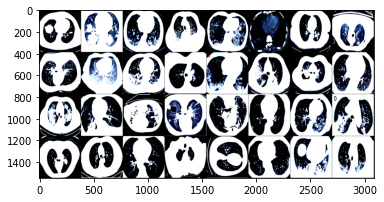

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


img scale min: -0.5589519739151001 max: 1.8200000524520874


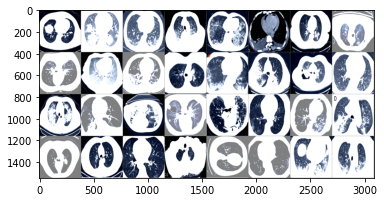

In [22]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import torchvision
import torchvision.transforms as transforms

# functions to show an image
# scale에 따른 시각화차이를 보여주기 위함
def imshow(img):
    print(f'img scale min: {img.min()} max: {img.max()}')
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

    plt.close()

    img = img / 2 + 0.5     # unnormalize 
    print(f'img scale min: {img.min()} max: {img.max()}')
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# get some random training images
dataiter = iter(train_dataloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))

#### Load model and other utils

In [23]:
# Load Model
model = custom_CNN(NUM_CLS).to(DEVICE)

# # Save Initial Model
# torch.save(model.state_dict(), 'initial.pt')

# Set optimizer, scheduler, loss function, metric function
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
scheduler =  optim.lr_scheduler.OneCycleLR(optimizer=optimizer, pct_start=0.1, div_factor=1e5, max_lr=0.0001, epochs=EPOCHS, steps_per_epoch=len(train_dataloader))
loss_fn = nn.BCELoss()
metric_fn = get_metric_fn

# Set trainer
trainer = Trainer(loss_fn, model, DEVICE, metric_fn, optimizer, scheduler)

# Set earlystopper
early_stopper = LossEarlyStopper(patience=EARLY_STOPPING_PATIENCE)

In [24]:
model

custom_CNN(
  (conv1): Conv2d(3, 8, kernel_size=(5, 5), stride=(1, 1))
  (conv_bn1): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(8, 16, kernel_size=(5, 5), stride=(1, 1))
  (conv_bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=138384, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=2, bias=True)
  (softmax): Softmax(dim=1)
)

### parameter 수

In [25]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)
count_parameters(model)

17717410

### epoch 단위 학습 진행

In [26]:
for epoch_index in tqdm(range(EPOCHS)):

    trainer.train_epoch(train_dataloader, epoch_index)
    trainer.validate_epoch(validation_dataloader, epoch_index)

    # early_stopping check
    early_stopper.check_early_stopping(loss=trainer.val_mean_loss)

    if early_stopper.stop:
        print('Early stopped')
        break

    if early_stopper.save_model:
        check_point = {
            'model': model.state_dict(),
            'optimizer': optimizer.state_dict(),
            'scheduler': scheduler.state_dict()
        }
        torch.save(check_point, 'vgg.pt')
        early_stopper.save_model = False


  0%|          | 0/30 [00:00<?, ?it/s]

Epoch 0, Train loss: 0.6593504581186507, Acc: 0.608433734939759, F1-Macro: 0.6042835662155719


  3%|▎         | 1/30 [04:51<2:21:02, 291.80s/it]

Epoch 0, Val loss: 0.6394821852445602, Acc: 0.7692307692307693, F1-Macro: 0.767247553115302
Epoch 1, Train loss: 0.5278331687053045, Acc: 0.7409638554216867, F1-Macro: 0.732642623291666


  7%|▋         | 2/30 [05:12<1:01:41, 132.19s/it]

Epoch 1, Val loss: 0.8139742016792297, Acc: 0.7846153846153846, F1-Macro: 0.782088122605364
Early stopping counter 1/10
Epoch 2, Train loss: 0.43271555337640977, Acc: 0.7882960413080895, F1-Macro: 0.7810066651344518
Epoch 2, Val loss: 0.4949118494405411, Acc: 0.7692307692307693, F1-Macro: 0.7683535281539557
Validation loss decreased 0.6394821852445602 -> 0.4949118494405411


 10%|█         | 3/30 [05:33<36:37, 81.39s/it]   

Epoch 3, Train loss: 0.3806023970246315, Acc: 0.802065404475043, F1-Macro: 0.7945670889189522


 13%|█▎        | 4/30 [05:53<24:51, 57.37s/it]

Epoch 3, Val loss: 2.5126712024211884, Acc: 0.7076923076923077, F1-Macro: 0.7065811356616774
Early stopping counter 1/10
Epoch 4, Train loss: 0.39644243692358333, Acc: 0.7925989672977625, F1-Macro: 0.7817564876792737
Epoch 4, Val loss: 0.48714333342650207, Acc: 0.8, F1-Macro: 0.799239724400095
Validation loss decreased 0.4949118494405411 -> 0.48714333342650207


 17%|█▋        | 5/30 [06:14<18:25, 44.23s/it]

Epoch 5, Train loss: 0.3792852217124568, Acc: 0.8055077452667814, F1-Macro: 0.7963818727669711
Epoch 5, Val loss: 0.4528545131906867, Acc: 0.7846153846153846, F1-Macro: 0.7841555977229602
Validation loss decreased 0.48714333342650207 -> 0.4528545131906867


 20%|██        | 6/30 [06:35<14:31, 36.32s/it]

Epoch 6, Train loss: 0.30866778186625904, Acc: 0.8313253012048193, F1-Macro: 0.824322364665772


 23%|██▎       | 7/30 [06:56<11:56, 31.15s/it]

Epoch 6, Val loss: 0.7223773620498832, Acc: 0.7692307692307693, F1-Macro: 0.7656813266041818
Early stopping counter 1/10
Epoch 7, Train loss: 0.32727886239687604, Acc: 0.8123924268502581, F1-Macro: 0.8031335001632032


 27%|██▋       | 8/30 [07:20<10:40, 29.12s/it]

Epoch 7, Val loss: 0.7586017996072769, Acc: 0.7538461538461538, F1-Macro: 0.7533206831119545
Early stopping counter 2/10
Epoch 8, Train loss: 0.2822975131372611, Acc: 0.8407917383820999, F1-Macro: 0.8340024354855027


 30%|███       | 9/30 [07:41<09:13, 26.38s/it]

Epoch 8, Val loss: 1.4578430205583572, Acc: 0.7846153846153846, F1-Macro: 0.7845643939393939
Early stopping counter 3/10
Epoch 9, Train loss: 0.29610920573274296, Acc: 0.8330464716006885, F1-Macro: 0.8252127580389044


 33%|███▎      | 10/30 [08:02<08:15, 24.78s/it]

Epoch 9, Val loss: 0.9739053845405579, Acc: 0.6923076923076923, F1-Macro: 0.6886973180076628
Early stopping counter 4/10
Epoch 10, Train loss: 0.2847902961075306, Acc: 0.8416523235800344, F1-Macro: 0.8353118789764762


 37%|███▋      | 11/30 [08:26<07:45, 24.49s/it]

Epoch 10, Val loss: 0.5797924847111062, Acc: 0.8, F1-Macro: 0.7969238163902908
Early stopping counter 5/10
Epoch 11, Train loss: 0.2659207172691822, Acc: 0.8364888123924269, F1-Macro: 0.8293290043290044


 40%|████      | 12/30 [08:47<07:05, 23.61s/it]

Epoch 11, Val loss: 0.6750504742376506, Acc: 0.7538461538461538, F1-Macro: 0.7523809523809524
Early stopping counter 6/10
Epoch 12, Train loss: 0.28478859385682476, Acc: 0.8442340791738382, F1-Macro: 0.8382779129806268


 43%|████▎     | 13/30 [09:14<06:56, 24.49s/it]

Epoch 12, Val loss: 0.7354085594415665, Acc: 0.8307692307692308, F1-Macro: 0.8266666666666667
Early stopping counter 7/10
Epoch 13, Train loss: 0.25894720400942284, Acc: 0.851118760757315, F1-Macro: 0.844881959635944


 47%|████▋     | 14/30 [09:34<06:11, 23.25s/it]

Epoch 13, Val loss: 0.5239318534731865, Acc: 0.7846153846153846, F1-Macro: 0.7841555977229602
Early stopping counter 8/10
Epoch 14, Train loss: 0.2868936343325509, Acc: 0.8390705679862306, F1-Macro: 0.8328017672871819


 50%|█████     | 15/30 [09:55<05:35, 22.38s/it]

Epoch 14, Val loss: 0.5730949195931316, Acc: 0.8307692307692308, F1-Macro: 0.8293148722845548
Early stopping counter 9/10
Epoch 15, Train loss: 0.2570650345749325, Acc: 0.8450946643717728, F1-Macro: 0.8386633961216272


 50%|█████     | 15/30 [10:15<10:15, 41.04s/it]

Epoch 15, Val loss: 0.5185891722212546, Acc: 0.7846153846153846, F1-Macro: 0.7845643939393939
Early stopping counter 10/10
Early stopped


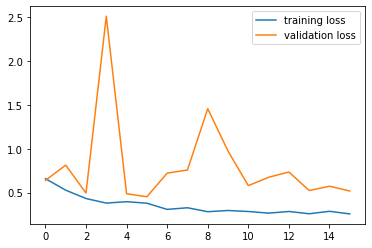

In [27]:
#Loss 확인
import matplotlib.pyplot as plt
plt.plot(running_loss_history, label='training loss')
plt.plot(val_running_loss_history, label='validation loss')
plt.legend()

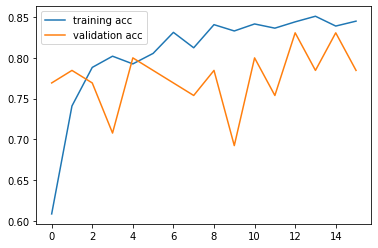

In [28]:
#acc 확인
plt.plot(running_corrects_history, label='training acc')
plt.plot(val_running_corrects_history, label='validation acc')
plt.legend()

## Inference
### 모델 로드

In [29]:
TRAINED_MODEL_PATH = 'vgg.pt'

### Load dataset

In [30]:
class TestDataset(Dataset):
    def __init__(self, data_dir, input_shape):
        self.data_dir = data_dir
        self.input_shape = input_shape
        
        # Loading dataset
        self.db = self.data_loader()
        
        # Transform function
        self.transform = transforms.Compose([transforms.Resize(self.input_shape),
                                             transforms.ToTensor(),
                                             transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

    def data_loader(self):
        print('Loading test dataset..')
        if not os.path.isdir(self.data_dir):
            print(f'!!! Cannot find {self.data_dir}... !!!')
            sys.exit()
        
        db = pd.read_csv(os.path.join(self.data_dir, 'sample_submission.csv'))
        return db
    
    def __len__(self):
        return len(self.db)
    
    def __getitem__(self, index):
        data = copy.deepcopy(self.db.loc[index])
        
        # Loading image
        cvimg = cv2.imread(os.path.join(self.data_dir,'test',data['file_name']), cv2.IMREAD_COLOR | cv2.IMREAD_IGNORE_ORIENTATION)
        if not isinstance(cvimg, np.ndarray):
            raise IOError("Fail to read %s" % data['file_name'])

        # Preprocessing images
        trans_image = self.transform(Image.fromarray(cvimg))

        return trans_image, data['file_name']

In [31]:
# Load dataset & dataloader
test_DATA_DIR = '/content/drive/MyDrive/모의경진대회/흉부 CT를 이용한 데이터 분석/data'
test_dataset = TestDataset(data_dir=test_DATA_DIR, input_shape=INPUT_SHAPE)
test_dataloader = DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=False)

Loading test dataset..


### 추론 진행

In [32]:
model.load_state_dict(torch.load(TRAINED_MODEL_PATH)['model'])

train_actual = []
validation_actual = []
train_pred_lst = []
validation_pred_lst = []

# train
model.eval()
with torch.no_grad():
    for batch_index, (img, label) in tqdm(enumerate(train_dataloader)):
        img = img.to(DEVICE)
        pred = model(img)
        train_actual += (list(label.numpy()))
        train_pred_lst.extend(pred.argmax(dim=1).tolist())

# valid
with torch.no_grad():
    for batch_index, (img, label) in tqdm(enumerate(validation_dataloader)):
        img = img.to(DEVICE)
        pred = model(img)
        validation_actual += (list(label.numpy()))
        validation_pred_lst.extend(pred.argmax(dim=1).tolist())


# test
file_lst = []
pred_lst = []
prob_lst = []
with torch.no_grad():
    for batch_index, (img, file_num) in tqdm(enumerate(test_dataloader)):
        img = img.to(DEVICE)
        pred = model(img)
        file_lst.extend(list(file_num))
        pred_lst.extend(pred.argmax(dim=1).tolist())
        prob_lst.extend(pred[:, 1].tolist())

37it [00:15,  2.44it/s]
3it [00:00,  4.18it/s]
4it [00:40, 10.03s/it]


In [33]:
# 평가 함수 정의
import seaborn as sns
import sklearn.metrics as metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, auc, confusion_matrix

def get_clf_eval(y_actual, y_pred):
    accuracy = accuracy_score(y_actual, y_pred)
    precision = precision_score(y_actual, y_pred)
    recall = recall_score(y_actual, y_pred)
    AUC = roc_auc_score(y_actual, y_pred)
    F1 = f1_score(y_actual, y_pred, average='macro')
    print('\n정확도: {:.4f}'.format(accuracy))
    print('정밀도: {:.4f}'.format(precision))
    print('재현율: {:.4f}'.format(recall))
    print('AUC: {:.4f}'.format(AUC))
    print('F1: {:.4f}'.format(F1))
    
    sns.heatmap(confusion_matrix(y_actual, y_pred), annot=True, fmt='d', cmap='YlGnBu')


정확도: 0.8236
정밀도: 0.9288
재현율: 0.6734
AUC: 0.8141
F1: 0.8166

정확도: 0.7846
정밀도: 0.7714
재현율: 0.8182
AUC: 0.7841
F1: 0.7842


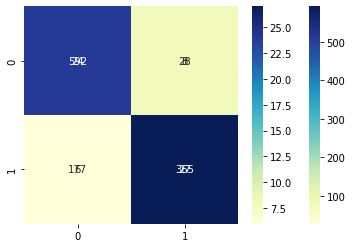

In [34]:
get_clf_eval(train_actual, train_pred_lst) # train set
get_clf_eval(validation_actual, validation_pred_lst) # validation set

### 결과 저장

In [35]:
# df = pd.DataFrame({'file_name':file_lst, 'COVID':pred_lst})
# # df.sort_values(by=['file_name'], inplace=True)
# df.to_csv('/content/drive/MyDrive/모의경진대회/흉부 CT를 이용한 데이터 분석/data2/vgg13_prediction2.csv', index=False)